## Prédisez la demande en électricité

Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

1. Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

2. Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
3. Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf, levinson_durbin, levinson_durbin_pacf, pacf_ols
from functions import plot_sortie_acf
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

<div class ="alert alert-block alert-info">

<a id='sommaire'></a>
### [1.Correction des données de consommation mensuelles de l'effet température par régression linéaire](#1)
* [1.1 Exploration et préparation des données de consommation ](#1.1)
* [1.2 Exploration et préparation des Données de chauffage](#1.2)
* [1.3 Correction de l'effet température par regression linéaire](#1.3)
    
      
### [2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles.](#2)
* [2.1 Préparation des données après correction](#2.1)
* [2.2 Méthode des moyennes mobiles](#2.2)


### [3. Prévision de la consommation corrigée de l'effet température sur un an avec la méthode de Holt Winters et SARIMA ](#3)
* [3.1 Préparation des données corrigée de l'effet température](#3.1)
* [3.2 La méthode Holt Winters](#3.2)
* [3.3 La méthode SARIMA](#3.3)
 
</div>

<a id='1'></a>
### 1. Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

<a id='1.1'></a>
#### 1.1 Exploration et préparation des données 

[Haut de page](#sommaire)

On va  selectionner la France dans la variable `Territoire`, pour avoir une représentation nationale et effectuer une projection de la variable`consommation totale`.

In [3]:
# lecture Table
conso_df = pd.read_csv("eCO2mix_RTE_energie_re.csv", encoding = "latin1", sep=";",index_col="Mois",parse_dates=False)
# projection territoire et consommation totale
conso_df = conso_df[['Territoire','Consommation totale']]
# restriction à la France 
conso_df = conso_df.loc[conso_df['Territoire']=='France',['Consommation totale']]
# prise en compte des valeurs superieur à 0
conso_df = conso_df.loc[conso_df['Consommation totale']>0,:]
conso_df

,Consommation totale
Mois,
2010-01,56342.0
2010-02,48698.0
2010-03,48294.0
2010-04,38637.0
2010-05,37284.0
...,...
2021-07,32959.0
2021-08,31184.0
2021-09,32350.0


In [4]:
# info sur conso_france
conso_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 2010-01 to 2021-11
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consommation totale  83 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


In [5]:
# Pourcentage des données manquantes par variables
prctManquants=conso_df.isna().sum()*100/conso_df.shape[0]
round(prctManquants.sort_values(),2)

Consommation totale    0.0
dtype: float64

In [6]:
# stat sur conso_france
conso_df.describe()

,Consommation totale
count,83.000000
mean,40239.048193
std,7242.368956
min,31004.000000
25%,34038.000000
50%,37747.000000
75%,45641.000000
max,57600.000000


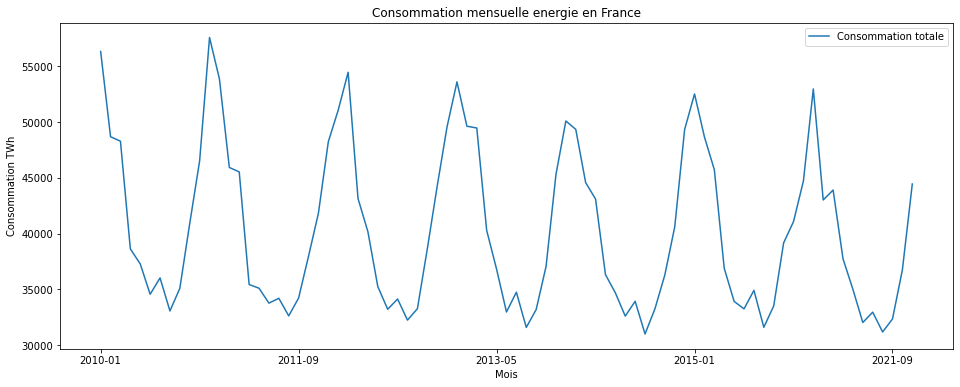

In [7]:
# visualtion temporelle de la consommation totale d'énergie
conso_df.plot(y="Consommation totale", figsize=(16,6))
plt.ylabel("Consommation TWh")
plt.title("Consommation mensuelle energie en France")
plt.savefig('Graph/Consommation mensuelle energie en France.png')

On note sur ce graphique que la tendance de la consommation d'énergie est stable avec chaque année une saisonnalité . Cependant ces variations à l'intérieur d'une même année fluctuent énormément. Afin de confirmer ces éléments nous allons transformer les valeurs en logarithme pour valider nos hypothèses.

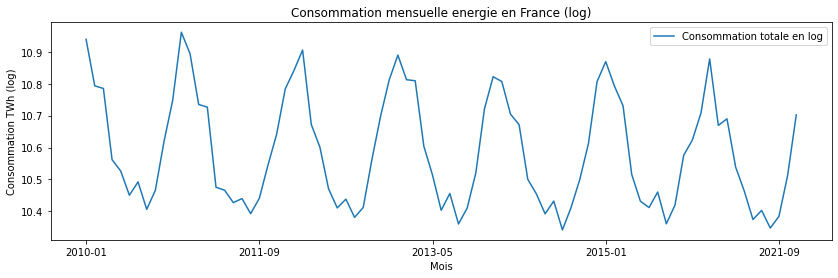

In [8]:
# Logarithme de la serie
np.log(conso_df['Consommation totale']).plot(figsize=(14,4))
plt.ylabel("Consommation TWh (log)")
plt.legend(labels=["Consommation totale en log"])
plt.title("Consommation mensuelle energie en France (log)")
plt.savefig('Graph/Consommation mensuelle energie en France (log).png')

Ce graphique en Logarithme confirme nos hypothèses, en effet, on a la meme tendance et saisonalité que notre serie temporelle en valeurs réelles. 

<div class ="alert alert-block alert-success">

**Resultats:**  
    
    
- On a importé une table de données à partir de  https://www.rte-france.com/eco2mix/telecharger-les-indicateurs qui représente la consommation d'énérgie (éléctrique) en France de 2010 à 2021. Neanmoins, on une période sans données du 01.2016 au 12.2020.
    
    
- Eu egard, à la tendance stable, à la saisonnalité de notre serie temporelle ainsi qu'à ces ecarts entre les pics et les creux stables sur une période au cours du temps, on peut affirmer que nous sommes face à un modèle additif : $X_t = T_t + S_t + \epsilon_t$.
    

</div>

<a id='1.2'></a>
**1.2 Exploration et préparation des Données de chauffage**

<div class ="alert alert-block alert-info">

**Infos:**    
    
    
- On va importer les fichiers excel de la consommation de chauffage en DJU (degrés-jours-unifiés) par région  de  https://cegibat.grdf.fr/simulateur/calcul-dju afin de préparer nos données de l'effet température (dues au chauffage électrique).
    
    
- Notre table contiendra les degrés-jours-unifiés (DJU) par région qu'on transformera en moyenne nationale.Afin de pouvoir faire le rapprochement avec notre premier dataframe sur la consommation nationale d'energie.
    
 
- RAPPEL : La définition des Degrés Jours Unifiés : c'est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli.Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment. 
    

</div>

[Haut de page](#sommaire)

In [9]:
# Chemin des fichiers
cwd = os.getcwd()
# selection conditionnelle des fichiers de chauffage dans le work directory
files = [file for file in os.listdir(cwd) if file.startswith("calcul_")]

In [10]:
# Concaténation des diffèrents fichiers régions
dju = pd.DataFrame()
# Pour chaque fichier dans files lire a partir de la 11 eme ligne et mettre en index la colonne 0 puis concat
for file in files :
    data = pd.read_excel(file, header=11, index_col=0)
    dju = pd.concat((dju,data))

# initialisation index
dju=dju.reset_index()
# definition de la colonne Annee
dju.rename(columns={dju.columns[0]:'Annee'}, inplace=True)
# Moyenne nationale
dju = dju.groupby(['Annee']).mean()
dju

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
Annee,,,,,,,,,,,,,
2009,450.414286,338.257143,272.928571,156.057143,52.228571,18.057143,6.742857,4.271429,23.042857,129.228571,204.314286,375.285714,2030.585714
2010,471.142857,355.371429,300.557143,156.542857,119.985714,18.928571,0.771429,10.385714,51.671429,159.742857,276.442857,453.271429,2374.557143
2011,392.714286,288.514286,248.500000,87.157143,42.542857,29.271429,15.757143,10.314286,20.485714,114.728571,200.828571,305.271429,1755.814286
2012,346.585714,442.600000,214.142857,200.100000,74.300000,21.885714,13.042857,3.328571,43.185714,126.200000,251.557143,331.071429,2067.700000
2013,390.542857,378.657143,313.728571,196.385714,143.228571,32.957143,1.042857,2.685714,28.228571,81.814286,284.428571,356.000000,2209.471429
2014,308.142857,270.928571,237.071429,129.400000,87.500000,11.542857,4.800000,15.542857,17.685714,67.028571,191.257143,344.200000,1684.871429
2015,366.757143,355.600000,254.185714,139.828571,68.714286,13.885714,5.271429,5.757143,50.571429,156.442857,191.071429,256.300000,1864.157143
2016,323.457143,290.971429,290.871429,191.271429,82.028571,18.742857,6.542857,2.957143,10.614286,156.371429,256.885714,376.471429,2007.028571
2017,452.628571,257.142857,198.142857,173.700000,67.057143,9.842857,2.671429,7.100000,52.771429,88.528571,276.142857,361.871429,1947.371429


In [11]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 2009 to 2021
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   JAN     13 non-null     float64
 1   FÉV     13 non-null     float64
 2   MAR     13 non-null     float64
 3   AVR     13 non-null     float64
 4   MAI     13 non-null     float64
 5   JUN     13 non-null     float64
 6   JUI     13 non-null     float64
 7   AOÛ     13 non-null     float64
 8   SEP     13 non-null     float64
 9   OCT     13 non-null     float64
 10  NOV     13 non-null     float64
 11  DÉC     13 non-null     float64
 12  Total   13 non-null     float64
dtypes: float64(13)
memory usage: 1.4 KB


In [12]:
# suppression colonne total
dju=dju.drop(columns=['Total'])
# on remplace les valeurs par une numerotation mensuelles
dju= dju.rename(columns={'JAN' : '1', 'FÉV' : '2', 'MAR' : '3','AVR' : '4', 'MAI' : '5','JUN' : '6',
                     'JUI' : '7', 'AOÛ' : '8', 'SEP' : '9','OCT' : '10','NOV' : '11','DÉC' : '12'})
dju

,1,2,3,4,5,6,7,8,9,10,11,12
Annee,,,,,,,,,,,,
2009,450.414286,338.257143,272.928571,156.057143,52.228571,18.057143,6.742857,4.271429,23.042857,129.228571,204.314286,375.285714
2010,471.142857,355.371429,300.557143,156.542857,119.985714,18.928571,0.771429,10.385714,51.671429,159.742857,276.442857,453.271429
2011,392.714286,288.514286,248.500000,87.157143,42.542857,29.271429,15.757143,10.314286,20.485714,114.728571,200.828571,305.271429
2012,346.585714,442.600000,214.142857,200.100000,74.300000,21.885714,13.042857,3.328571,43.185714,126.200000,251.557143,331.071429
2013,390.542857,378.657143,313.728571,196.385714,143.228571,32.957143,1.042857,2.685714,28.228571,81.814286,284.428571,356.000000
2014,308.142857,270.928571,237.071429,129.400000,87.500000,11.542857,4.800000,15.542857,17.685714,67.028571,191.257143,344.200000
2015,366.757143,355.600000,254.185714,139.828571,68.714286,13.885714,5.271429,5.757143,50.571429,156.442857,191.071429,256.300000
2016,323.457143,290.971429,290.871429,191.271429,82.028571,18.742857,6.542857,2.957143,10.614286,156.371429,256.885714,376.471429
2017,452.628571,257.142857,198.142857,173.700000,67.057143,9.842857,2.671429,7.100000,52.771429,88.528571,276.142857,361.871429


In [13]:
# préparation liste pour df
chauff_df={'mois':[],'chauffage':[]}
# remplir le dictionnaire chauff_df 
for Année in dju.index.values:
    for mois in dju.columns:
        chauff_df['mois'].append(f"{Année}-{mois}")
        chauff_df['chauffage'].append(dju.loc[Année,mois])         
        
# Création du DataFrame 
chauff_df=pd.DataFrame(chauff_df)
#chauff_df['Mois']=pd.to_datetime(chauff_df['Mois'])
chauff_df

,mois,chauffage
0,2009-1,450.414286
1,2009-2,338.257143
2,2009-3,272.928571
3,2009-4,156.057143
4,2009-5,52.228571
...,...,...
151,2021-8,0.000000
152,2021-9,0.000000
153,2021-10,0.000000
154,2021-11,0.000000


In [14]:
# verification des données manquantes
manquant_chau=chauff_df.isna().sum()
manquant_chau

mois         0
chauffage    0
dtype: int64

In [15]:
# reinitialisation Index pour merge
conso_df=conso_df.reset_index()
# changement Dtype pour merege
conso_df['Mois']=pd.to_datetime(conso_df['Mois'])

In [16]:
# Application dtype Datetime variable Mois
chauff_df['mois']=pd.to_datetime(chauff_df['mois'])
# Jointure gauche droite des dataframe consommation totale energie et DJU chauffage 
df_1=conso_df.merge(chauff_df,left_on='Mois',right_on='mois')
# Définition de la variable mois comme index
df_1=df_1.drop(['mois'],axis=1).set_index('Mois')
# Filtrer valeurs supérieurs à 0
df_1 = df_1.loc[df_1['chauffage']>0,:]
# Exporter au format Csv
df_1.to_csv('df_1.csv')
# Lectue de la table df_1
df_1 = pd.read_csv("df_1.csv",index_col="Mois",parse_dates=False)

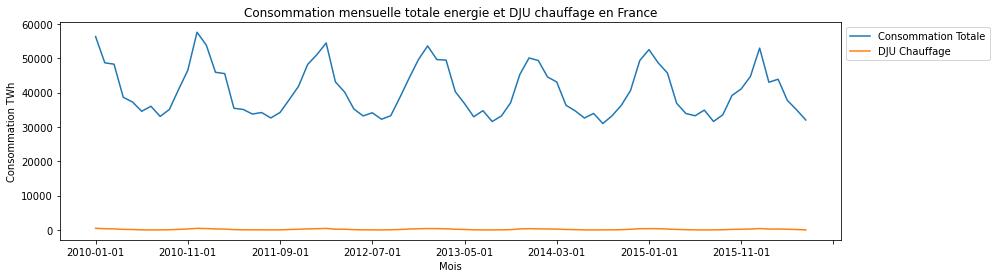

In [17]:
# Visualisation de la consommation mensuelle totale energie et DJU chaufage
df_1['Consommation totale'].plot(figsize=(14,4),label="Consommation Totale")
df_1['chauffage'].plot(figsize=(14,4),label="DJU Chauffage")
plt.ylabel("Consommation TWh")
plt.title("Consommation mensuelle totale energie et DJU chauffage en France")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Graph/Consommation mensuelle totale energie et DJU chauffage en France.png')

On note sur ce graphique une consommation totale d'energie stable avec une saisonalité. Quant au DJU chauffage il semble avoir une tendance stable sans saisonnalité. Cependant afin de confirmer ces éléménts nous allons passer nos valeurs en logarithme pour valider nos hypothèses.

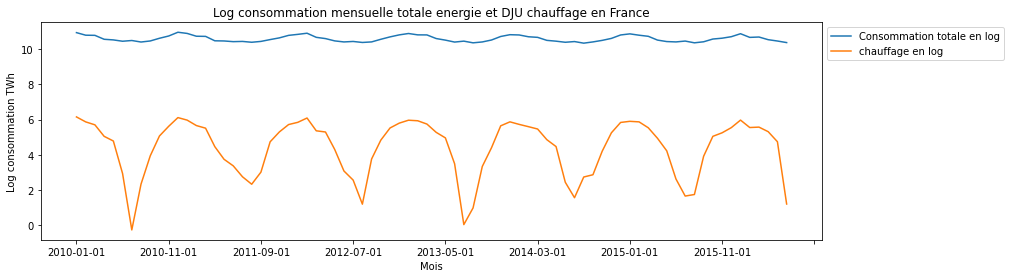

In [18]:
# Visualisation de la consommation mensuelle totale energie et DJU chaufage en logarithme
np.log(df_1['Consommation totale']).plot(figsize=(14,4),label="Consommation totale en log")
np.log(df_1['chauffage']).plot(figsize=(14,4),label="chauffage en log")
plt.ylabel("Log consommation TWh")
plt.title("Log consommation mensuelle totale energie et DJU chauffage en France")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Graph/Log consommation mensuelle totale energie et DJU chauffage en France.png')

Sur ce graphique, on peut voir pour la consommation totale nos hypothèses ce confirmer. Cependant pour le DJU chauffage, ce passage en logarithme nous confirme bien sa tendance relativement stable, nénmoins, on peut voir qu'il existe une saisonnalité contrairement au premier graphique avec les valeurs réelles. De plus, cette saisonnalité semble etre synchrone avec la saisonalité de la consommation d'energie totale. 

In [19]:
# lecture des caracteristiques de la table
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2010-01-01 to 2021-06-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consommation totale  78 non-null     float64
 1   chauffage            78 non-null     float64
dtypes: float64(2)
memory usage: 1.8+ KB


<div class ="alert alert-block alert-success">

**Résultats:**  
        
- On a concatené tous les fichiers fichiers excel de la consommation de chauffage par région du 01.2009 au 06.2021 issues de https://cegibat.grdf.fr/simulateur/calcul-dju.
    
    
- Ensuite, on a preparé le dataframe obtenue pour une jointure avec le dataframe de la consommation total d'energie en France `conso_df` et créer un dataframe les regroupants `df_1`.
    
    
- Eu egard, à la tendance stable, à la saisonnalité de notre serie temporelle du DJU Chauffage ainsi qu'à ces ecarts entre les pics et les creux stables sur une période au cours du temps, on peut affirmer que nous sommes face à un modèle additif et qu'elle est sychrone avec la serie temporelle de la consommation d'energie en France.
    

</div>

<a id='1.3'></a>
#### 1.3  Correction de l'effet température par regression linéaire

[Haut de page](#sommaire)

<div class ="alert alert-block alert-info">

**Infos:**    
    
On va decomposer notre serie en une base tendancielle et une base saisonière :          

$ \ $   
       
$$Tendancielle :  \displaystyle T_t = \sum_{i=1}^{n} \alpha_{i} T_t^{(i)}  \   Saisonniere :  \displaystyle S_t = \sum_{j=1}^{p} \beta_{j} S_t^{(j)}$$
    
    
    
    
$ \ $     
     
    
On va essayer d'estimer le modèle de régression linéaire suivant:
    
$ \ $      
    
$  \displaystyle \forall t  \in  \begin{Bmatrix} {1,...,78}\end{Bmatrix}: Y_t = a+b_t+ \sum_{i=1}^{12} c_i 1$ 

    
$ \ $    
             
Néanmoins, eu egard au problème de la somme des indicatrices qui vaut 1 et qui est deja une variable dans notre modele, on a un problème de colinéarité,donc, on ne peut pas estimer le modèle commme il est.
    
$ \ $   
    
$  \displaystyle \sum_{i=1}^{12} 1_{mois=i} {(t)=1}$
  
$ \ $ 
    
Aussi,on va transformer le probleme pour se ramener à une regression linéaire classique. Pour ce faire, on va obtenir une estimation de $a$, $b$ et de tout les $c_i$, afin de corriger le logarithme de notre serie temporelle.

$ \ $   
    
    
 $  \displaystyle \forall t  \in  \begin{Bmatrix} {1,...,78}\end{Bmatrix}: Y_t^{CVS} = Y_t - \sum_{i=1}^{12} \hat c_i 1_{mois=i} (t)$ 
    
    
Enfin, on va revenir à notre serie de depart en repassant en exponentielle  et on va visualiser notre serie corrigée par rapport à la serie initiale .
    

$ \ $   
    
    
$  \displaystyle X_t^{CVS} = exp(Y_t^{CVS})$    
      
</div>

In [20]:
# Prise en compte des valeurs superieur à 0 pour omettre les données maquantes de juin à nov 2021
df_1 = df_1.loc[df_1['chauffage']>0,:]

In [21]:
# stokage des valeurs dans variables series 'x' et 'y' en logarithme
x = df_1
y = np.log(df_1)

In [22]:
# création de la bases tendancielle 
t = range(1,79 )
# Création de la base saisonnière en créant 12 indicatrices pour Janv, Fev,.. 
for i in range(12):
    su = np.repeat(0, repeats=12)
    su[i] = df_1.shape[0]+1
    s = np.tile(su, 78 // len(su) + 1)[:78]
    vars()['s' + str(i+1)] = s

In [23]:
# Régression linéaire de y (logarithme consommation energie sur t, s1 jusqu'à s12
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(np.array([t, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12]).transpose(), y)

LinearRegression(fit_intercept=False)

In [24]:
# Affichage des coefficient
print(reg.coef_)

[[-0.00098304  0.13810663  0.1368453   0.13626363  0.1339472   0.13310754
   0.13229682  0.13277948  0.13178904  0.13247197  0.13408727  0.13562388
   0.13742978]
 [-0.00305501  0.07657257  0.07487927  0.07188534  0.06523591  0.05811119
   0.0363192   0.01902345  0.02543256  0.04553058  0.06128579  0.0703806
   0.07525821]]


In [25]:
# On revient aux coefficients initiaux :
# moyenne des 12 coefficients saisonniers 
a = np.mean(reg.coef_[0][1:13])
# coefficient devant t
b = reg.coef_[0][0]
# prends les coef s1 à s12 retranché de la moyenne
c = reg.coef_[0][1:13] - a

In [26]:
# calcul de la serie corrigée des variations sur le logarithme... 
# ...retrancher à 'y' la somme des 12 coef saisonniers multiplié par les 12 indicatrices"
y_cvs = y['Consommation totale'] - (c[0]*s1+c[1]*s2+c[2]*s3+c[3]*s4+c[4]*s5+c[5]*s6+c[6]*s7+c[7]*s8+c[8]*s9+c[9]*s10+c[10]*s11+c[11]*s12)
# calcul de la serie corrigée des variation saisonnière sur la serie de départ (on repasse en exponentiel)
x_cvs = np.exp(y_cvs)

In [27]:
# Integration des série sous forme de Dataframe
serie_Corri = pd.DataFrame(x_cvs).reset_index() # Df serie Corrigé des variations
serie_corri=serie_Corri.rename(columns={'Consommation totale': 'Consommation_corrigee'}, inplace=True)
serie_norm = pd.DataFrame(x)#.reset_index()# Df série non corrigé

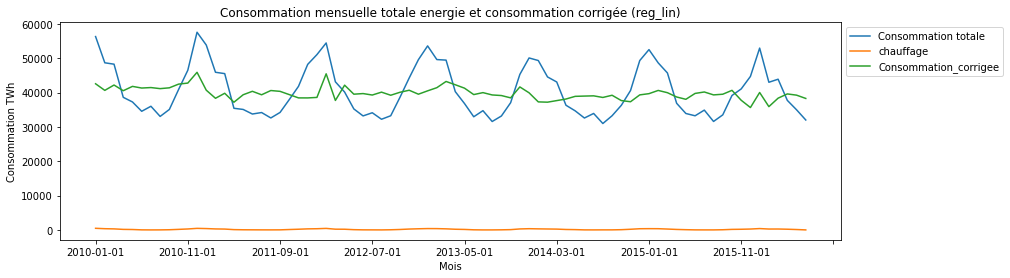

In [28]:
# on renomme consommation totale
x_cvs = x_cvs.rename("Consommation_corrigee")
# visualisation serie non corrigée
x.plot(figsize=(14,4),label="Consommation Totale")
# visualisation serie corrigée
x_cvs.plot(figsize=(14,4),label='Consommation_corrigee')
# label ordonnée                                     
plt.ylabel("Consommation TWh")
# titre
plt.title("Consommation mensuelle totale energie et consommation corrigée (reg_lin)")
# legende
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Graph/Consommation mensuelle totale energie et consommation corrigée (reg_lin).png')

<div class ="alert alert-block alert-success">

**Résultat:**    
     
$ \ $    

Le graphique nous indique les niveaux de consommation de la consommation mensuelle d’énergie et la consommation corrigée de l’effet de température (chauffage)en TWh entre janvier 2010 et décembre 2015.
     
$ \ $    
On obtient une tendance de la consommation corrigé qui traduit un niveau moyen stable et une saisonnalité qui est centré.     

</div>

<a id='2'></a>
### 2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles.

<a id='2.1'></a>
#### 2.1 Préparation des données après correction

[Haut de page](#sommaire)

In [29]:
# création du dataframe des consommations corrigees pour effectuer la desaisonalisation
serie_Corrig_df= pd.DataFrame({'Mois':x_cvs.index, 'Consommation_corrigee':x_cvs.values})
# Definition de `Mois` comme index
serie_Corrig_df=serie_Corrig_df.set_index('Mois')
serie_Corrig_df

,Consommation_corrigee
Mois,
2010-01-01,42582.538185
2010-02-01,40661.724969
2010-03-01,42220.604774
2010-04-01,40561.092029
2010-05-01,41825.088092
...,...
2021-02-01,35924.063720
2021-03-01,38390.554053
2021-04-01,39626.770733


In [30]:
# lecture des caracteristiques du df
serie_Corrig_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2010-01-01 to 2021-06-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Consommation_corrigee  78 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB


<a id='2.2'></a>
#### 2.2 Méthode des moyennes mobiles

<div class ="alert alert-block alert-info">

**Infos:** 
    
    
On va effectuer une décompositions de notre serie temporelle en utilisant des moyennes mobiles. Pour ce faire on va utiliser le polynôme caractéristique de la moyenne mobile :
    
     
$ \ $    

$$  \displaystyle Θ(z) = \sum_{i=0}^{m1+m2} θ_{i−m1}z^i$$ 
    
$ \ $
       
    
Mettre en evidence les diffèrentes composantes de notre serie temporelle, et ainsi pouvoir corriger les variations saisonnières.Notre moyenne mobile ici est une combinaison linéaire d'instants passés et futurs, on va l'utiliser comme un filtre .
    
$ \ $   
    
$$MX_t=θ_{−m1}X_{t−m1}+…+θ{−1}X_{t−1}+θ_0X_t+θ1X_{t+1}+…+θ_{m2}X_{t+m2}$$
    
   
 $ \ $
    
soit notre serie temporel $X_t=T_t+S_t+ \varepsilon_t$
    
$ \ $
    
On applique une moyenne mobile M sur la série :
    
$ \ $
    
$$MX_t=MT_t+MS_t+ M\varepsilon_t$$
    
$ \ $
    
- Avec comme hypothèses :
    - $MT_t = T_t$, une tendance invariante
    - $MS_t = 0$, une saisonnalité absorbée
    - $M\varepsilon_t$,'faible' attenuation de la variance
    
$ \ $
  
Enfin, aprés avoir estimé la saisonnalité et obtenu les coefficients  saisonniers, on va les retrancher à notre serie après correction de l'effet temperature, pour obtenir notre serie temporelle desaisonnalisée.
    
$ \ $
    
$$ X_t^{CVS}=X_t− \hat S_t$$


</div>

[Haut de page](#sommaire)

In [31]:
# Décomposition saisonière
decomp_x = seasonal_decompose(
    x_cvs,
    model="additive",
    filt=None,
    period=12,
    two_sided=True,
    extrapolate_trend=0);

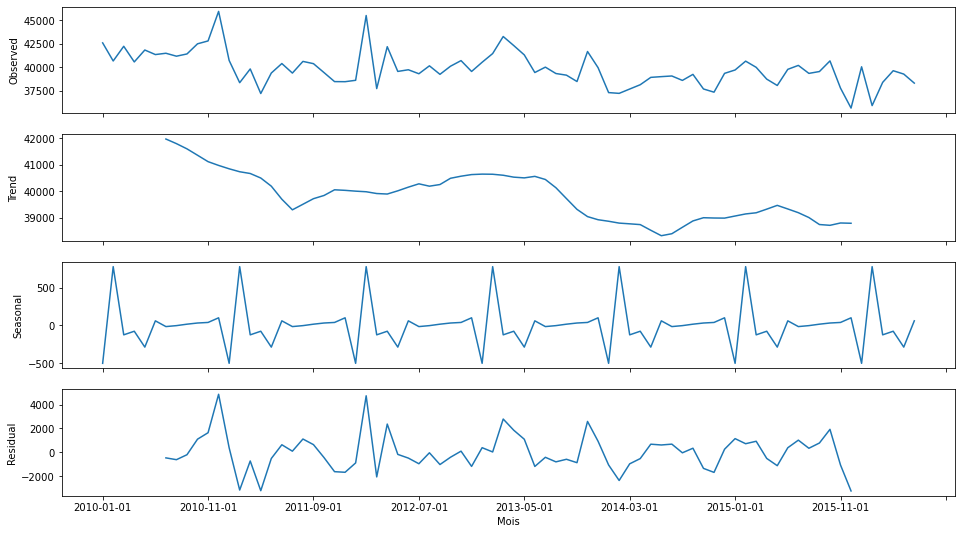

In [32]:
# Visualisation graphique de la décomposition saisonnière
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 9))
decomp_x.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomp_x.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomp_x.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomp_x.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.savefig('Graph/ Décomposition de la consommation corrigée.png')
plt.show()

In [33]:
# On retranche les coef saisoniers aux consommation corrigées pour alimenter une nouvelle variable 'desaisonnalisee_corrigee'
serie_Corrig_df['desaisonnalisee_corrigee']= x_cvs.values - decomp_x.seasonal.values
serie_Corrig_df

,Consommation_corrigee,desaisonnalisee_corrigee
Mois,,
2010-01-01,42582.538185,43087.960628
2010-02-01,40661.724969,39882.280548
2010-03-01,42220.604774,42347.325271
2010-04-01,40561.092029,40639.931228
2010-05-01,41825.088092,42114.696301
...,...,...
2021-02-01,35924.063720,35144.619299
2021-03-01,38390.554053,38517.274550
2021-04-01,39626.770733,39705.609932


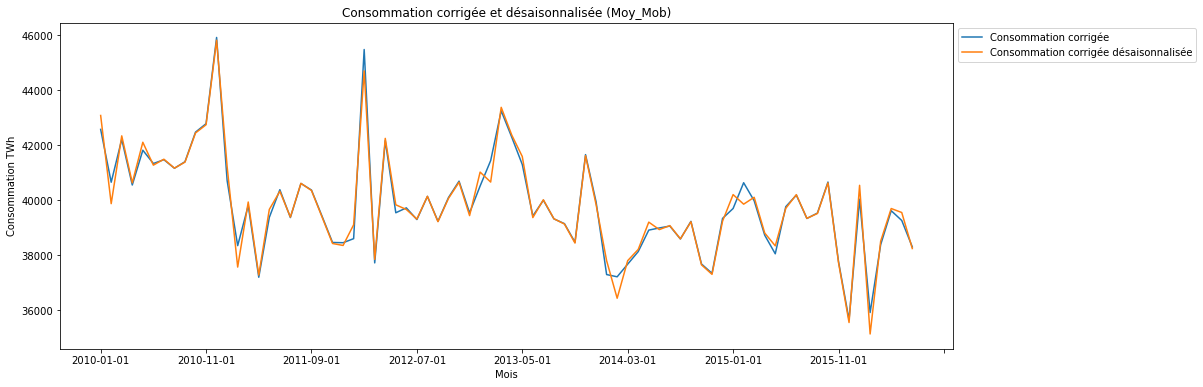

In [34]:
# visualisation serie consommation corrigée et désaisonalisée (CVS)
serie_Corrig_df['Consommation_corrigee'].plot(figsize=(16,6),label='Consommation corrigée')
# visualisation serie corrigée desaisonnalisé
serie_Corrig_df['desaisonnalisee_corrigee'].plot(figsize=(16,6),label='Consommation corrigée désaisonnalisée')                                     
# label ordonnée                                     
plt.ylabel("Consommation TWh")
# titre
plt.title("Consommation corrigée et désaisonnalisée (Moy_Mob)")
# legende
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Graph/Consommation corrigée et désaisonnalisée (Moy_Mob).png')

<div class ="alert alert-block alert-success">

**Résultat:**  
$ \ $    
Le graphique nous indique les niveaux de consommation corrigée et la consommation corrigée désaisonnalisée en TWh entre janvier 2010 et décembre 2015.

$ \ $ 
Notre série temporelle est invariante et absorbée à savoir rendue nulle par les moyennes mobiles. En somme, notre série temporelle conserve sa tendance. 

$ \ $ 
Quant au pouvoir de réduction de variance entre entrée et sortie, à savoir atténuer la perturbation (bruit blanc faible), on note peu d'atténuations de la variance. 
    

</div>

<a id='3'></a>
### 3. Prévision de la consommation corrigée de l'effet température sur un an avec la méthode de Holt Winters et SARIMA 

<a id='3.1'></a>
#### 3.1 Préparation des données corrigée de l'effet température

In [35]:
# copy DataFrame
serie_CVS_h=serie_Corrig_df.copy()
#serie_CVS_h = serie_CVS_h[['Mois','CVS']]
serie_CVS_h=serie_CVS_h.reset_index()
# Projection des variables de travail
serie_CVS_h=serie_CVS_h[['Mois','Consommation_corrigee']]
serie_CVS_h

,Mois,Consommation_corrigee
0,2010-01-01,42582.538185
1,2010-02-01,40661.724969
2,2010-03-01,42220.604774
3,2010-04-01,40561.092029
4,2010-05-01,41825.088092
...,...,...
73,2021-02-01,35924.063720
74,2021-03-01,38390.554053
75,2021-04-01,39626.770733
76,2021-05-01,39270.755789


In [36]:
# selection période sur laquelle on va travailler
serie_CVS_h = serie_CVS_h.loc[serie_CVS_h['Mois'] < '2014-01-01']
# Transformation date pour la visualisation
serie_CVS_h['Mois']=pd.to_datetime(serie_CVS_h['Mois'])
# selection de la serie corigée
y_hW= np.asarray(serie_CVS_h['Consommation_corrigee'])

<a id='3.2'></a>
#### 3.2 La méthode de Holt-Winters

<div class ="alert alert-block alert-info">

**Infos:** 
    
La méthode de Holt-Winters est effectivement la seul qui est vraiement pratiquable pour notre prévision car elle prend en compte la saisonnalité, en effet, si l'on considère seulement LES (lissage exponentielle simple) ou LED (lissage exponentielle double), on approxime notre serie temporelle soit par une constante soit par une droite.Ausi, comme demandé, on va utiliser la méthode de Holt-Winters pour effectuer notre prédiction. 

$ \ $    

Notre prévision est une fonction passé de notre serie et son objectif est de prévoir à la date T une série temporelle à un horizon $\ell$ à partir de $T$ observations $(X1,…,XT)$.
 
$ \ $
    
La méthode Holt-Winters consiste à supposer que $X_t$ est approximable au voisinage de $T$  par $aT+(t−T)bT+ST$ et $s$  étant la période du cycle saisonnier de la série temporelle.    
    
$ \ $     
      
$$\begin{cases} \hat a_T= (1−α)(XT− \hat S_{T−s}) + \alpha( \hat a_{T−1} + \hat b_{T−1} \\ \hat b_T=(1− \beta )( \hat a_T− \hat a_{T−1}) + \beta \hat b_{T−1} \\ \hat S_T= (1− \gamma)(XT− \hat a_T)+ \gamma \hat S_{T−s} \end{cases}$$

    
$ \ $     
      
    
Les parametres de la méthode sont $\alpha$, $\beta$ et  $\gamma$. Concernant la prévion on a : 

        
$ \ $     
  

$$\begin{cases} \hat X_{T(\ell)} = \hat a_{T+\ell} \hat b_T + \hat S_{T+\ell−s} \ \ \ \ si \ \ell∈{1,…,s}  \\  \hat X_{T(\ell)} = \hat a_{T+\ell} \hat b_T + \hat S_{T+\ell−2s}  \ \ \ \  si \ \ell∈{s+1,…,2s}  \\ {…} \end{cases}$$

</div>

[Haut de page](#sommaire)

In [37]:
# application de la méthode Holt-Winters
h_W = ExponentialSmoothing(y_hW,seasonal_periods=12, trend='add', seasonal='add').fit()
h_W_pred = h_W.forecast(12)

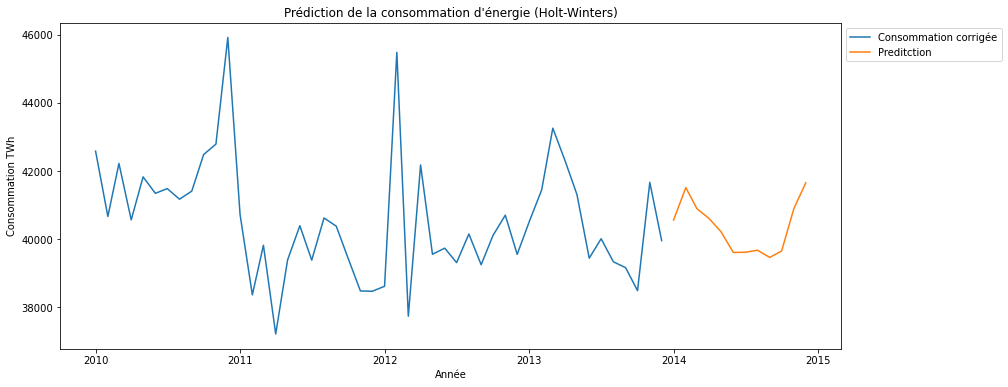

In [38]:
# visualisation serie consommation corrigée et désaisonalisée (CVS) methode Holt Winter
# parametre de taille graphique
plt.figure(figsize=(14,6))
# Variables à visualiser 'Mois' et 'prediction'
plt.plot(serie_CVS_h['Mois'],serie_CVS_h['Consommation_corrigee'], label='Consommation corrigée')
plt.plot(pd.date_range(serie_CVS_h.Mois[serie_CVS_h.shape[0]-1],periods=12, freq='M'), h_W_pred, label='Preditction')
# label ordonnée                                     
plt.ylabel('Consommation TWh')
# label abcisse
plt.xlabel('Année')
# titre
plt.title("Prédiction de la consommation d\'énergie (Holt-Winters)")
# legende
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Graph/Prédiction de la consommation d\'énergie (Holt-Winters).png')

On note sur ce graphique une prédiction qui s'inscrit dans la continuité d'une tendance stable de la consommation corrigée.

 On verifie si notre courbe de prediction resssemble à celle que l'on a sur la période 2014 .

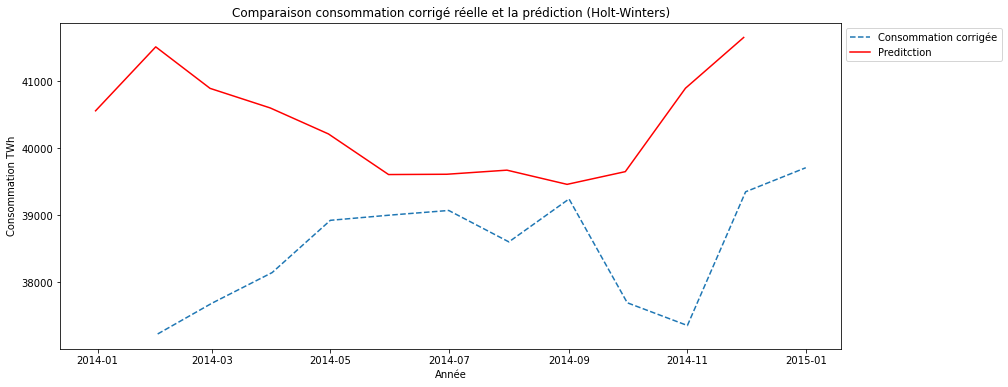

In [39]:
# Restriction à l'année 2014
serie_Corri['Mois']=pd.to_datetime(serie_Corri['Mois'])
serie_Corri_comp = serie_Corri.loc[serie_Corri['Mois'] > '2014-01-01']
serie_Corri_comp = serie_Corri_comp.loc[serie_Corri_comp['Mois'] < '2015-02-01']


# visualisation comparaison serie consommation corrigée et prediction
# parametre de taille graphique
plt.figure(figsize=(14,6))
# Variables à visualiser 'Mois' et 'prediction'
plt.plot(serie_Corri_comp['Mois'],serie_Corri_comp['Consommation_corrigee'], linestyle='--', label='Consommation corrigée')
plt.plot(pd.date_range(serie_CVS_h.Mois[serie_CVS_h.shape[0]-1],periods=12, freq='M'), h_W_pred,  color='r', label='Preditction')
# label ordonnée                                     
plt.ylabel('Consommation TWh')
# label abcisse
plt.xlabel('Année')
# titre
plt.title("Comparaison consommation corrigé réelle et la prédiction (Holt-Winters)")
# legende
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('Graph/"Comparaison consommation corrigé réelle et la prédiction (Holt-Winters)".png')

<div class ="alert alert-block alert-success">

**Résultat:**  

On note sur ce graphique annuel de comparaison une tendance stable pour la prédiction et une tendance plutôt croissante pour la consommation réelle pour l'année 2014.
    
$ \ $  
    
Il semble cohérent car la saisonnalité est mieux prise en compte par la méthode Holt-Winters contrairement à la consommation réelle corrigée qui approxime la saisonnalité (Primo-estimation) et n'est pas tout à fait désaisonnalisée.
    
$ \ $  
        
Neanmoins, toutes les méthodes que nous venons de tester sont déterministes, à savoir, qu'à aucun moment il n'y a de notion de variable aléatoire, ces outils sont faibles, aussi, dans la partie suivante, nous allons essayer une modelisation stochastique d'une série temporelle en appliquant à nos données une structure aléatoire pour établir de bonnes prévisions.
    
</div>    

## <a id='3.3'></a>
#### 3.3 La méthode SARIMA

<div class ="alert alert-block alert-info">

**Infos:**    
 
$ \ $       
La démarche adoptée est la suivante :
    
$ \ $      

- stationnarisation (éventuellement),    
    
- Identification, estimation et validation de modèles
    
- Prévision à l'aide du modèle choisi,

- Analyse a posteriori de la prévision.
    

</div>

### Stationnarisation (éventuelle) de la série : 

**RAPPEL:** La stationnarité c'est la propriété d'une série temporelle à garder ses caractéristiques inchangées au passage du temps. Elle implique l'absence de tendance et de saisonnalité dans les données ainsi qu'une moyenne et une variance constantes pour la série temporelle.
 
Eu egard à la tendance et à la saisonnalité de notre serie ainsi qu'au faible nombre d'observations qu'on a pu collecter, on va travailler non pas sur la série mais sur des différences de la série avec l'operateur de différenciation $ \nabla_s^{D}$ au lieu de $X_t$:

$$ \nabla_s^{D}=(I−B_s)^D$$

In [40]:
#df_1['Mois']=pd.to_datetime(df_1['Mois'])
serie_Corri = serie_Corri.loc[serie_Corri['Mois'] < '2016-01-01']
serie_Corri=serie_Corri.set_index('Mois')

# stokage des valeurs dans variables series 'x' et 'y' en logarithme
x = serie_Corri
y = np.log(serie_Corri)

L'autocorrélogramme simple :

l'autocorrélogramme simple  noté $\rho$ permet de calculer la corrélation entre $X_t$ et $X_{t-h}$.c'est une simple normalisation de la fonction d'autocovariance.

$$\forall{h}∈ ℤ : \rho(h) = Corr(X_t,X_t−h) = \dfrac{\gamma (h)}{\gamma(0)}$$
    

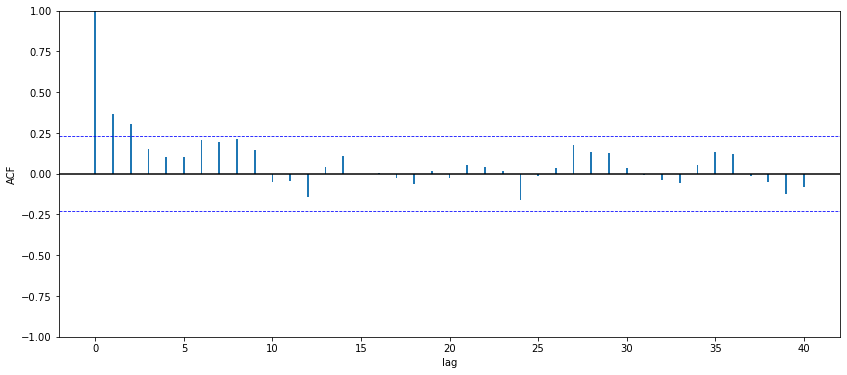

In [41]:
# Identification du nombre de décalage autorégressifs (AR) et le nombre de décalage de moyenne mobile (MA) avec la fonction d'autocorrélation simple 
y_len = len(y['Consommation_corrigee']) # variable nécessaire pour l'utilisation de plot_sortie_acf
# viusalisation graphique de l'autocorellation simple
plot_sortie_acf(acf(np.asarray(y['Consommation_corrigee'])), y_len)

La sortie ACF indique une décroissance sinusoïdale vers 0, aussi on va on va effectuer une différenciation $(I−B)$.

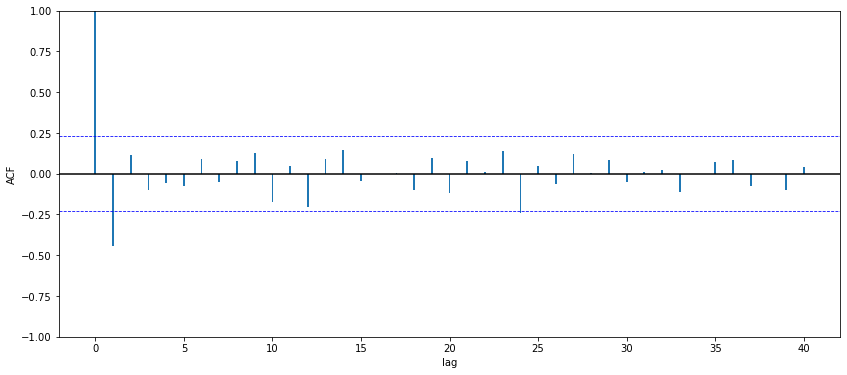

In [42]:
# 1ère Differenciation en tendance
y_dif1 = y['Consommation_corrigee'] - y['Consommation_corrigee'].shift(1)

plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

La sortie ACF nous indique toujours une décroissance sinusoïdale vers 0, Aussi, on va effectuer  la différenciation $(I−B^{12})$ car on a un modele autoregressive d'ordre 12.

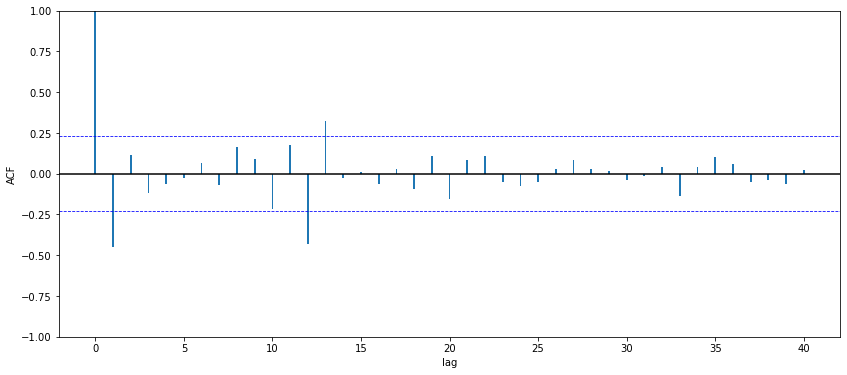

In [43]:
# 2 ème Différenciation  en saisonnalité
y_dif_1_12 = y_dif1 - y_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len)

La sortie ACF de la série doublement différenciée decroit de manière sinusoïdale amortie et semble etre un autocorrélogramme simple empirique. On est ici face à un modèle SARIMA sur la série $(I−B)(I−B12)ln(X_t)$.

#### Identification, estimation et validation de modèles

On va s’appuier sur les autocorrélogrammes simple et partiels estimés

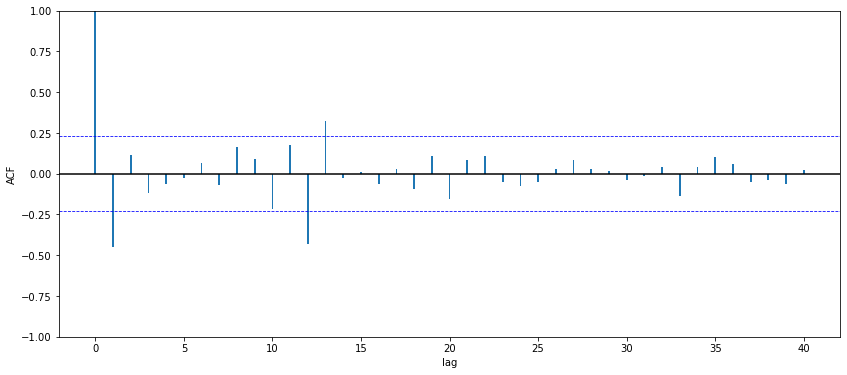

In [44]:
# Visualisation graphique de l'autorrélogramme simple differencié 12
y_dif_1_12 = y_dif1 - y_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len)

Autocorrélogramme partiel : 

l'autocorrélogramme partiel noté $r$ permet de connaître la corrélation entre 2 instants éloignés d'un processus conditionnellement aux instants intermédiaires.

soit une relation entre $X_t$ et $X_{t-1}$.

$$r(0)=1$$

$$r(1)=\rho(1)$$
    

$$\forall{h} ∈ ℕ \backslash \{0,1\} : r(h) = Corr ( X_t,X_{t−h} / X_{t−1},…,X_{t−h+1})$$

$ \ $ 

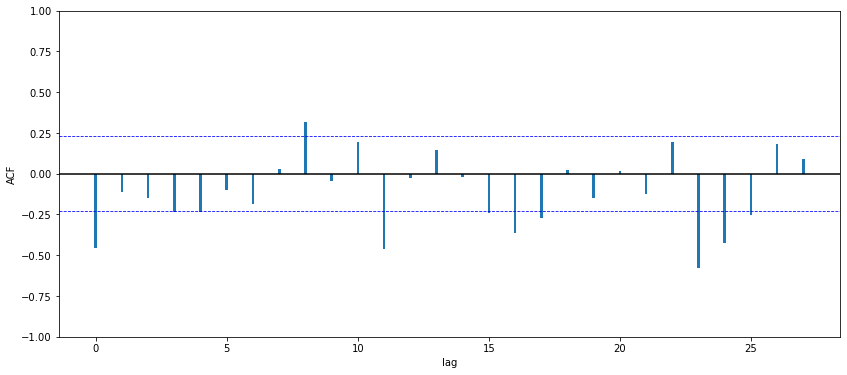

In [45]:
# Visualisation graphique de l'autorrélogramme partiel differencié 12
pacf_= pacf(y_dif_1_12[13:], nlags=28)
plot_sortie_acf(pacf_,y_len, pacf=True)

En somme,malgré une série doublement différenciée, il reste une structure dans la serie temporelle qu'on va essayer d'approximer sur la base de l'analyse du corrélogramme partiel de la diffèrence saisionnère d'ordre 12 qui présente des pics aux retards 1, 12 et 24 et de la fonction d'autocorrelation qui présente une decroissance sinusoïdale amortie.

#### Modèle 1

Eu egard aux autocorrélogrammes empiriques simples et partiels , on estime d'abord un modèle $SARIMA(1,1,1)(1,1,1)_{12}$. On écrit ce modèle :

$$(I−φ_{1}B)(I−φ′_{1}B^{12})(I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [84]:
# importation 
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(y['Consommation_corrigee']), order=(1,1,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()                           # composante non saisonière  # composante saisonière 
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  91.203
Date:                            Sat, 28 May 2022   AIC                           -172.406
Time:                                    13:12:07   BIC                           -162.018
Sample:                                         0   HQIC                          -168.351
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2615      0.127      2.059      0.039       0.013       0.510
ma.L1         -0.9856      0.681   

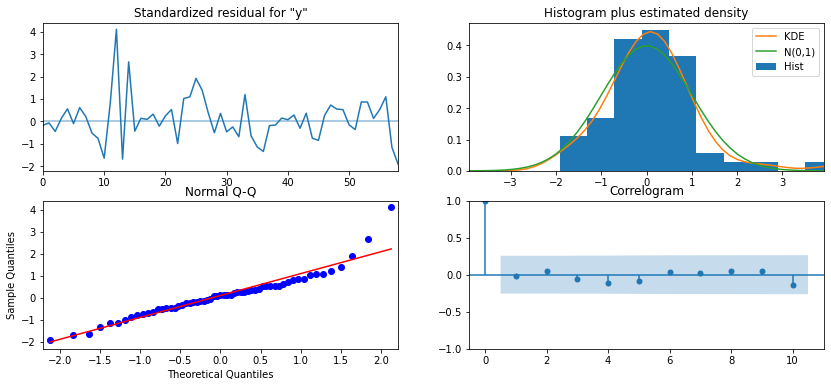

In [85]:
# Visualisation resultat modèle 1
results1.plot_diagnostics(figsize=(14,6))
plt.show()

Ce modèle ayant des paramètres non significatifs, on teste un deuxième modèle.

#### Modèle 2

Soit le modèle :
$$ (I−φ′_{1}B)ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [86]:
model2 = SARIMAX(np.asarray(y['Consommation_corrigee']), order=(1,1,0), seasonal_order=(0,1,0,12))
results2 = model2.fit()                        # composante non saisonière  # composante saisonière 
print(results2.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  74.097
Date:                            Sat, 28 May 2022   AIC                           -144.194
Time:                                    13:12:23   BIC                           -140.039
Sample:                                         0   HQIC                          -142.572
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4572      0.089     -5.164      0.000      -0.631      -0.284
sigma2         0.0047      0.001   

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

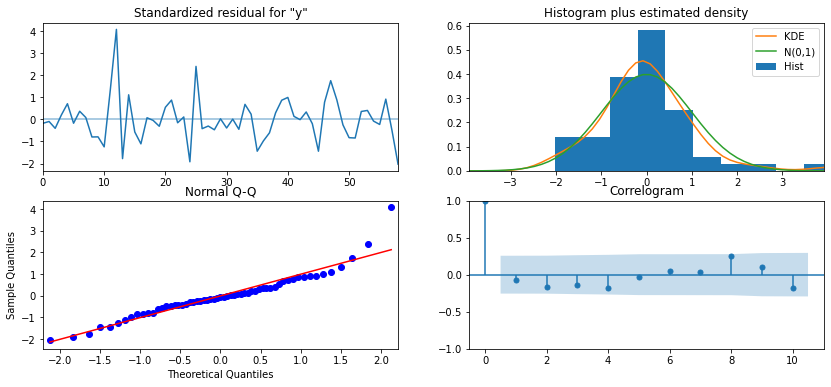

In [87]:
# Visualisation modèle 2
results2.plot_diagnostics(figsize=(14,6))
plt.show()

*La blancheur et la normalité du résidu :*

On remarque qu'a partir du retard 6 que les 'P-value' de la statistique de Ljung-Box son strictement superieur à 0.05, ce qui indique une absence d'autocorrelation et donc un bruit blanc.

In [88]:
from scipy.stats import shapiro
shapiro(results2.resid)

ShapiroResult(statistic=0.20511221885681152, pvalue=7.745913643390501e-18)

Le test de normalité est validé pour ce modèle.

<div class ="alert alert-block alert-success">
    
**Résultats :**   
  
Les tests de significativité des paramètres, La blancheur et la normalité du résidu nous indiquent que le modèle le plus convenable est le modèle 2.C'est un modèle autoregressif d'ordre 1.
    
</div>

#### Prévision à l’aide du modèle 2 :

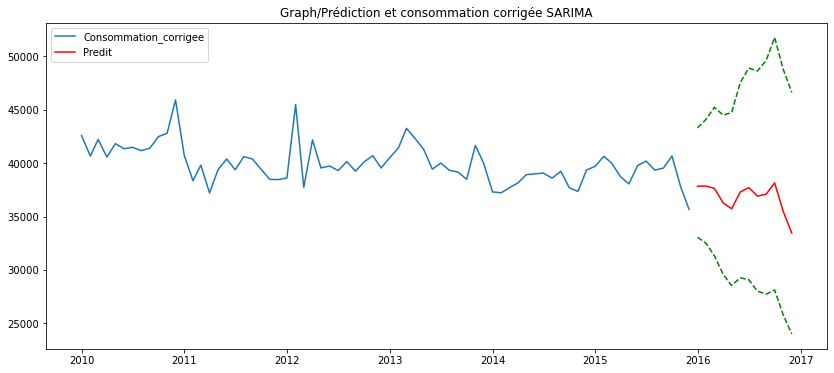

In [68]:
pred_model2 = results2.get_forecast(12)
pred = np.exp(pred_model2.predicted_mean)
pred_2 = [np.exp(elt[0]) for elt in pred_model2.conf_int(alpha=0.05)]
pred_u = [np.exp(elt[1]) for elt in pred_model2.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x['Consommation_corrigee'], label='Consommation_corrigee')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_2, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Graph/Prédiction et consommation corrigée SARIMA")
plt.legend()
plt.savefig('Graph/Prédiction et consommation corrigée SARIMA.png')
plt.show()

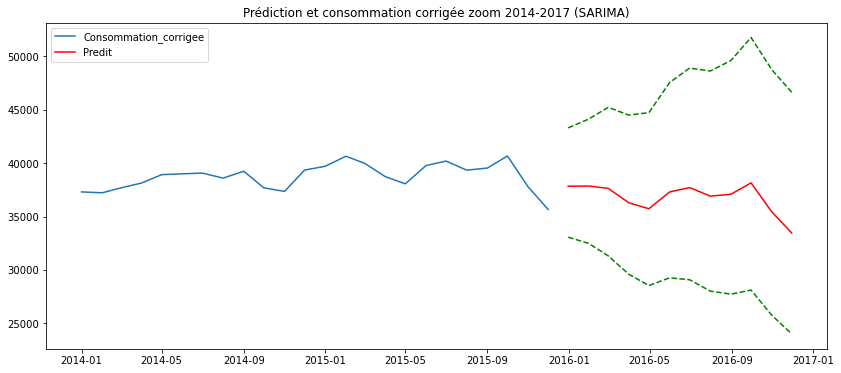

In [69]:
# zoom sur la periode
plt.figure(figsize=(14,6))
plt.plot(x['Consommation_corrigee']['2014':], label='Consommation_corrigee')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_2, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédiction et consommation corrigée zoom 2014-2017 (SARIMA)")
plt.legend()
plt.savefig('Graph/Prédiction et consommation corrigée zoom 2014-2017 (SARIMA).png')
plt.show()

L'allure de nos graphiques semble cohérente au vu du passé de notre serie temporell mais, on n'a pas de certitude sur la qualité de notre prévision aussi, aussi, on va effectuer une analyse à posteriori.

#### Analyse a posteriori

On va quantifier les écarts entre les prévisions et les réalisations. On va tronquer de la série l'année 2015 qu’on va chercher ensuite à prévoir à partir de l’historique 2010-2014.

In [70]:
# decoupage de notre dataframe
x_tronc = x[:'2014']
y_tronc = np.log(x_tronc)
x_a_prevoir = x['2015':]

In [77]:
# On vérifie notre modèle 1 sur la série tronquée
model2tronc = SARIMAX(np.asarray(y_tronc['Consommation_corrigee']), order=(1,1,0), seasonal_order=(0,1,0,12))
results2tronc = model2tronc.fit()
print(results2tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2tronc.resid, lags=elt)[1].mean()))
    
shapiro(results2tronc.resid)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  58.657
Date:                            Sat, 28 May 2022   AIC                           -113.315
Time:                                    13:11:01   BIC                           -109.615
Sample:                                         0   HQIC                          -111.923
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5389      0.105     -5.122      0.000      -0.745      -0.333
sigma2         0.0048      0.001   

ShapiroResult(statistic=0.2265721559524536, pvalue=3.8603613921387424e-16)

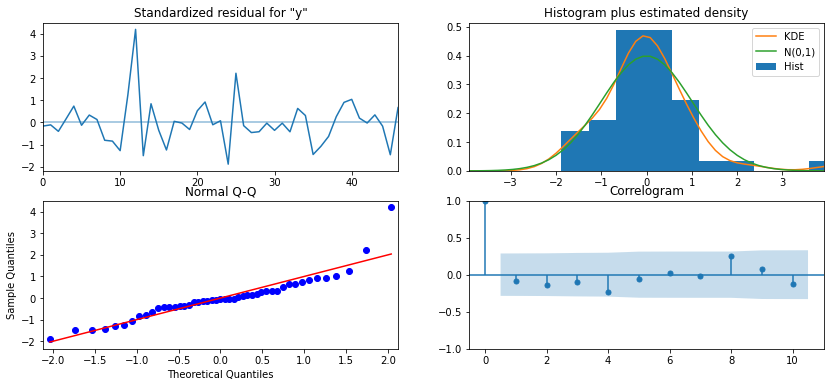

In [78]:
results2tronc.plot_diagnostics(figsize=(14,6))
plt.show()

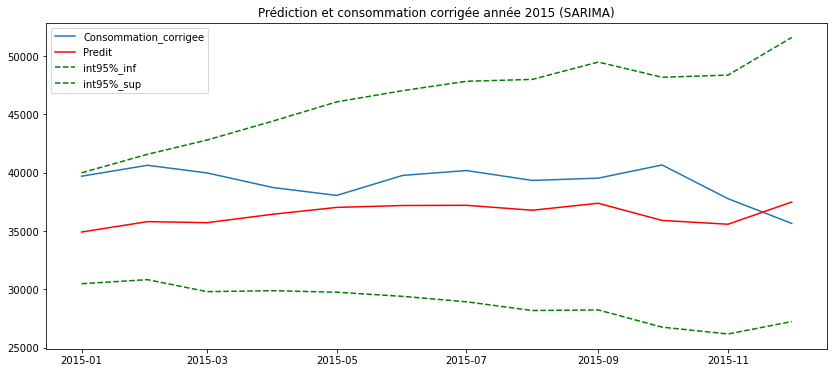

In [79]:
# Visualisationd de la prédiction
pred_model2tronc = results2tronc.get_forecast(12)
pred_tronc = np.exp(pred_model2tronc.predicted_mean)
pred_2_tronc = [np.exp(elt[0]) for elt in pred_model2tronc.conf_int(alpha=0.05)]
pred_u_tronc = [np.exp(elt[1]) for elt in pred_model2tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation_corrigee')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_2_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.title("Prédiction et consommation corrigée année 2015 (SARIMA)")
plt.legend()
plt.savefig('Graph/Prédiction et consommation corrigée année 2015 (SARIMA).png')
plt.show()



On note dans ce graphique une prédiction annuelle qui est très proche de la réalisation en bleu et elle s'inscrit dans l'intervalle de confiance. On obtient une prédiction convenable . Cependant on va quantifier nos résultats avec le calcul de critères d'erreurs.
    

On calcule les RMSE et MAPE.

$\displaystyle\ RMSE=\sqrt{ \frac {1}{T} \sum_{t=1}^{T} (x_t − \hat x_t)^2}$
    
$\displaystyle\ MAPE= \sqrt{\frac {1}{T} \sum_{t=1}^{T} ∣\frac {x_t− \hat x_t}{x_t}∣}$

In [80]:
# Root means squar error (erreur quadratique moyenne)
rmse = np.sqrt(((x_a_prevoir['Consommation_corrigee']-pred_tronc)**2).mean())
rmse

3266.647982501157

In [81]:
# Mean Average Percentage error (erreur relative en moyenne)
mape=(np.abs(1-pred_tronc/x_a_prevoir['Consommation_corrigee'])).mean()*100
mape

7.636553063984366

L’interprétation des critères d’erreur dépend de la série et de la qualité de prévision exigée, neanmoins, on peut affirmer que notre modele avec une RMSE de 3266.64 et une MAPE à 7.63 % nous donne un resultat acceptable. 

<div class ="alert alert-block alert-success">

**Résultats:**    
    
Avec la méthode SARIMA on a identifié, puis estimé et validé notre modèles. Ensuite, on a utilisé notre modèle pour effectuer des previsions a priori acceptables eu egard à l'analyse effectuée à posteriori.
    
    
Néanmoins, la prudence est de mise car notre modèle s'appuie sur un nombre faible d'observations.
    
</div>

## Références

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

https://stackoverflow.com/questions/16504975/error-unsupported-format-or-corrupt-file-expected-bof-record

https://stackoverflow.com/questions/47405628/bokeh-utf8-codec-cant-decode-byte-0xe9-unexpected-end-of-data

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html

https://stackoverflow.com/questions/64617482/valueerror-you-must-specify-a-period-or-x-must-be-a-pandas-object-with-a-dateti

https://openclassrooms.com/fr/courses/4525371-analysez-et-modelisez-des-series-temporelles/5001626-decouvrez-des-algorithmes-de-traitement-des-moyennes-mobiles

https://perso.math.univ-toulouse.fr/jydauxoi/files/2017/04/poly_eleves.pdf

https://eric.univ-lyon2.fr/~jjacques/Download/Cours/ST-Cours.pdf

https://searchcode.com/codesearch/view/86129185/

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html